In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import ephem
from astropy.time import Time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates

The SpaceX STARLINK constellation is expected to consist of almost 12000 satellites. The original constellation consists of 8 orbital shells (https://fcc.report/IBFS/SAT-LOA-20170301-00027/1190019):

Five shells are in LEO constellation: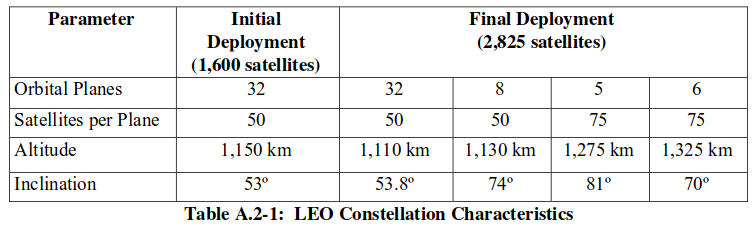

Another 3 shells in the VLEO constellation: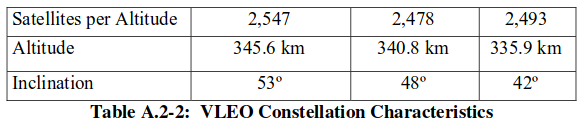

Where the satellites in the LEO constellation are spread over orbital planes and within orbital planes, the VLEO satellites will occupy unique orbital planes.

SpaceX subsequently requested that the 1150 km shell be lowered to 550 km (https://fcc.report/IBFS/SAT-MOD-20181108-00083/1569859.pdf), and that these 1584 satellites are spread over 72 orbital planes with 22 satellites each (https://fcc.report/IBFS/SAT-MOD-20190830-00087/1877764.pdf).

With this information, we can define the orbital shells as follows:

In [2]:
alt = np.array([550, 1110, 1130, 1275, 1325, 345.6, 340.8, 335.9])*u.km
incl = np.array([53.0, 53.8, 74.0, 81.0, 70.0, 53.0, 48.0, 42.0])
nplane = np.array([72, 32, 8, 5, 6, 2547, 2478, 2493])
nsat_per_plane = np.array([22, 50, 50, 75, 75, 1, 1, 1])

This class describes the two-line element sets (TLEs) used to model the STARLINK orbits with SGP4/SDP4.

In [3]:
class twolineelement:
    """TLE class"""

    def __init__(self, tle0, tle1, tle2):
        """Define a TLE"""

        self.tle0 = tle0
        self.tle1 = tle1
        self.tle2 = tle2
        if tle0[:2] == "0 ":
            self.name = tle0[2:]
        else:
            self.name = tle0
            if tle1.split(" ")[1] == "":
                self.id = int(tle1.split(" ")[2][:4])
            else:
                self.id = int(tle1.split(" ")[1][:5])

The TLEs use `mean motion` instead of the orbital altitude. This function computes the mean motion from the orbital altitude (using WGS84 constants).

In [4]:
def compute_mean_motion(a, mu=398600.5*u.km**3/u.s**2, rearth=6378.137*u.km):
    no = np.sqrt(4.0*np.pi**2*(a+rearth)**3/mu)
    return (1.0/no).to(1.0/u.day).value

The last digit in a TLE line is the checksum, which some software requires to be correct.

In [5]:
def set_checksum(line):
    s = 0
    for c in line[:-1]:
        if c.isdigit():
            s += int(c)
        if c == "-":
            s += 1
    return line[:-1]+"%d"%(s%10)

Some of the STARLINK satellites are spread equally over distinct orbital planes. This function computes TLEs for that case.

In [6]:
def generate_tles_in_equal_planes(mm, incl, epoch, nsat_per_plane, nplane):
    # Generate lists
    mas = np.linspace(0.0, 360.0, nsat_per_plane, endpoint=False)
    raans = np.linspace(0.0, 360.0, nplane, endpoint=False)

    # Empty list
    tles = []

    # Loop over RAAN and mean anomaly
    satno = 80000
    for raan in raans:
        for ma in mas:
            tle0 = "Object %05d"%satno
            tle1 = set_checksum("1 %05dU 20001A   %14.8lf  .00000000  00000-0  50000-4 0    08" % (satno, epoch))
            tle2 = set_checksum("2 %05d %8.4f %8.4f 0001000   0.0000 %8.4f %11.8lf    08" % (satno, incl, raan, ma, mm))

            tles.append(twolineelement(tle0, tle1, tle2))
            satno += 1
    
    return tles

The STARLINK satellites in the lower shells are randomly distributed. Here, it is assumed that the distribution of the orbital planes and the location of the satellites within each orbital plane are random.

In [7]:
def generate_tles_in_random_planes(mm, incl, epoch, nplane):
    # Generate lists
    ma = 360.0*np.random.random(nplane)
    raan = 360.0*np.random.random(nplane)

    # Empty list
    tles = []

    # Loop over RAAN and mean anomaly
    satno = 90000
    for i in range(len(raan)):
        tle0 = "Object %05d"%satno
        tle1 = set_checksum("1 %05dU 20001A   %14.8lf  .00000000  00000-0  50000-4 0    08" % (satno, epoch))
        tle2 = set_checksum("2 %05d %8.4f %8.4f 0001000   0.0000 %8.4f %11.8lf    08" % (satno, incl, raan[i], ma[i], mm))

        tles.append(twolineelement(tle0, tle1, tle2))
        satno += 1
    
    return tles

Compute the mean motion for each orbital shell.

In [8]:
mm = compute_mean_motion(alt)

We can now generate TLEs for the STARLINK megaconstellation using the properties of the 8 orbital shells.

In [9]:
tles = []
for i in range(len(alt)):
    if nsat_per_plane[i]>1:
        newtles = generate_tles_in_equal_planes(mm[i], incl[i], 20180.0, nsat_per_plane[i], nplane[i])
    else:
        newtles = generate_tles_in_random_planes(mm[i], incl[i], 20180.0, nplane[i])        
    for tle in newtles:
        tles.append(tle)

Save these TLEs to a file.

In [10]:
with open("tles.txt", "w") as fp:
    for tle in tles:
        fp.write("%s\n%s\n%s\n" % (tle.tle0, tle.tle1, tle.tle2))

Given the location of an observer, the TLEs of the STARLINK satellites can be used to calculate how many of them are sunlit at any time above a given minimum elevation.

In [11]:
def compute_visibility(observer, min_alt, nday, nstep, ntime):
        
    # Loop over days
    nvis = np.zeros(nday*ntime).reshape(nday, ntime).astype("int")
    for i, mjd in enumerate(np.arange(mjd0, mjd0+nday*nstep, nstep)):
        for j, h in enumerate(np.linspace(0.0, 24.0, ntime, endpoint=False)):
            t = Time(mjd+h/24.0, format="mjd")
    
            observer.date = ephem.date(t.datetime)

            # Loop over TLEs
            nvisible = 0
            neclipsed = 0
            for tle in tles:
                sat = ephem.readtle(tle.tle0, tle.tle1, tle.tle2)
                sat.compute(observer)

                if (sat.alt>min_alt*np.pi/180.0) & (sat.eclipsed==False):
                    nvisible += 1
                elif (sat.alt>min_alt*np.pi/180.0) & (sat.eclipsed==True):
                    neclipsed += 1

            nvis[i, j] = nvisible
    return nvis

Let's compute the visibility of different latitudes (the longitude dependence is negligible).

In [ ]:
for latitude in np.arange(-70, 80, 10):
    # Set observer
    observer = ephem.Observer()
    observer.lon = "0.000"
    observer.lat = str(latitude)
    observer.elevation = 0.0

    # Minimum elevation
    min_alt = 30.0
    
    # Start time
    mjd0 = Time("2020-01-01T00:00:00", format="isot").mjd

    # Time and day settings
    nday = 72 #
    nstep = 5
    ntime = 72
    
    nvis = compute_visibility(observer, min_alt, nday, nstep, ntime)
    np.save("latitude_%+03d" % latitude, nvis)

This function creates the plot showing how many satellites are sunlit at a given time.

In [12]:
def create_plot(city, latitude, fname):
    # Load
    nvis = np.load("latitude_%+03d.npy" % latitude)
    
    # Set observer
    observer = ephem.Observer()
    observer.lon = "0.000"
    observer.lat = str(latitude)
    observer.elevation = 0.0

    # Minimum elevation
    min_alt = 30.0
    
    # Start time
    mjd0 = Time("2020-01-01T00:00:00", format="isot").mjd

    # Time and day settings
    nday = 72 #
    nstep = 5
    ntime = 72

    # Find sunrise/sunset
    mjdrise = np.zeros(nday)
    mjdset = np.zeros(nday)
    for i, mjd in enumerate(np.arange(mjd0, mjd0+nday*nstep, nstep)):
        # Get sunrise/sunset
        t = Time(mjd, format="mjd")
        observer.date = ephem.date(t.datetime)
        try:
            trise = observer.next_rising(ephem.Sun())
            mjdrise[i] = Time(trise.datetime(), scale="utc").mjd
        except:
            mjdrise[i] = np.nan
        try:
            tset = observer.next_setting(ephem.Sun())
            mjdset[i] = Time(tset.datetime(), scale="utc").mjd
        except:
            mjdset[i] = np.nan

    c = ~np.isnan(mjdrise)
    xr, yr = 24*(mjdrise[c]%1), mdates.date2num(Time(np.floor(mjdrise[c]), format="mjd").datetime)
    c = ~np.isnan(mjdset)
    xs, ys = 24*(mjdset[c]%1), mdates.date2num(Time(np.floor(mjdset[c]), format="mjd").datetime)
    
    tmin = mdates.date2num(Time(mjd0, format="mjd").datetime)
    tmax = mdates.date2num(Time(mjd0+nday*nstep, format="mjd").datetime)
    
    # Make plot
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.plot(xr, yr, color="k", linestyle=":", label="Sunrise")
    ax.plot(xs, ys, color="k", linestyle="--", label="Sunset")
    ax.legend()

    # Prevent drawing choppy contours
    contours = np.array([10, 20, 40, 80])
    c = contours<0.6*np.max(nvis)
    
    img = ax.imshow(nvis, origin="lower", aspect="auto", extent=[0, 24, tmin, tmax], cmap="inferno")
    cs = ax.contour(nvis, contours[c], extent=[0, 24, tmin, tmax], colors="C0")
    ax.clabel(cs, inline=1, fontsize=10, fmt="%d")
        
    ax.set_title(r"$\phi = %g^\circ$ (%s), %d SpaceX STARLINK satellites, $A > %g^\circ$"%(latitude, city, np.sum(nplane*nsat_per_plane), min_alt))
    ax.set_xlabel("Time of day (h)")
    ax.set_ylabel("Date")
    
    ax.yaxis_date()
    date_format = mdates.DateFormatter("%F")
    ax.yaxis.set_major_formatter(date_format)
    fig.autofmt_xdate(rotation=0, ha="center")
    ax.set_xticks(np.arange(0, 24), minor=True)
    ax.set_xticks(np.arange(0, 24, 4))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.6)
    cbar = fig.colorbar(img, cax=cax, orientation="vertical");
    cbar.set_label("Number of sunlit satellites")
    
    plt.tight_layout()
    plt.savefig(fname, dpi=100, bbox_inches="tight")

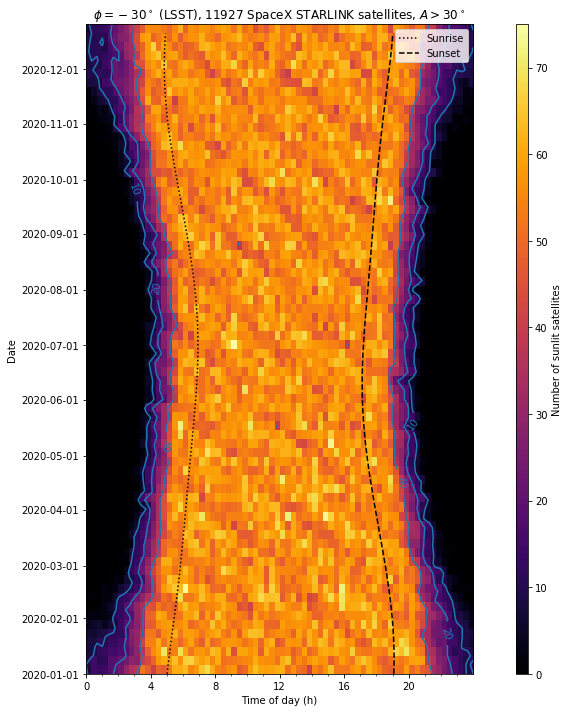

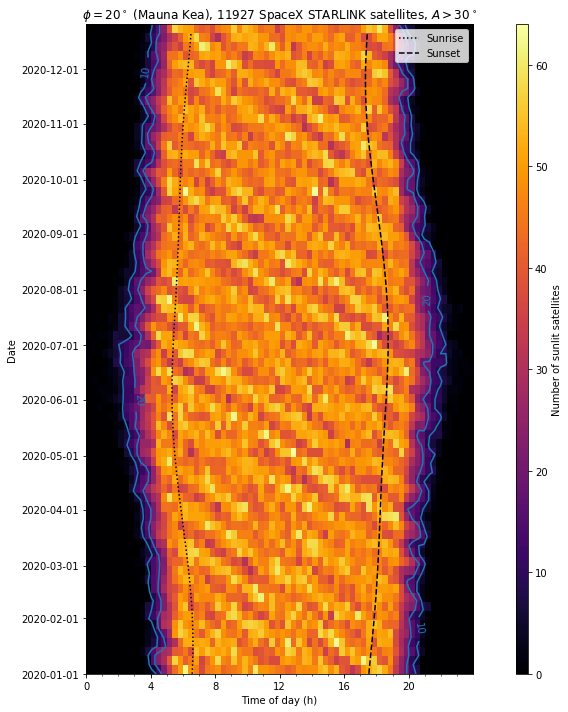

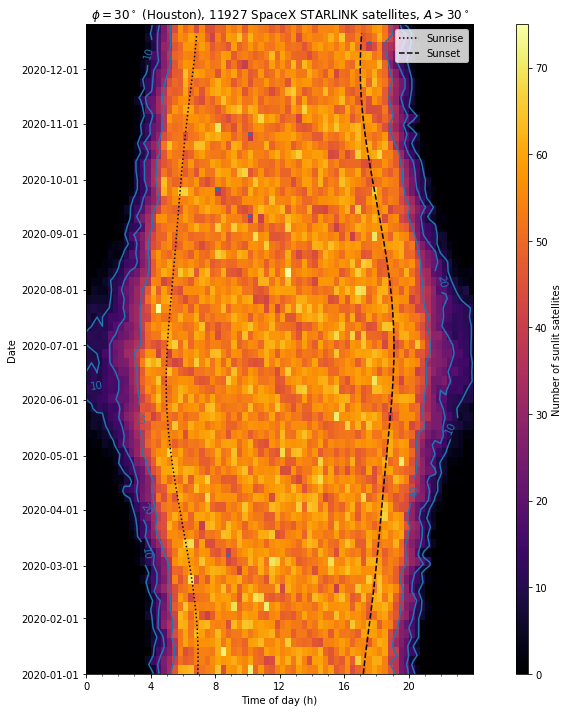

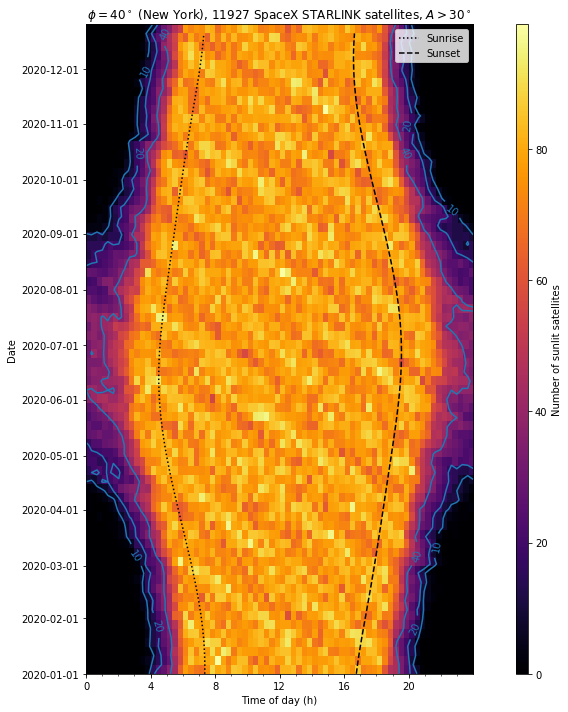

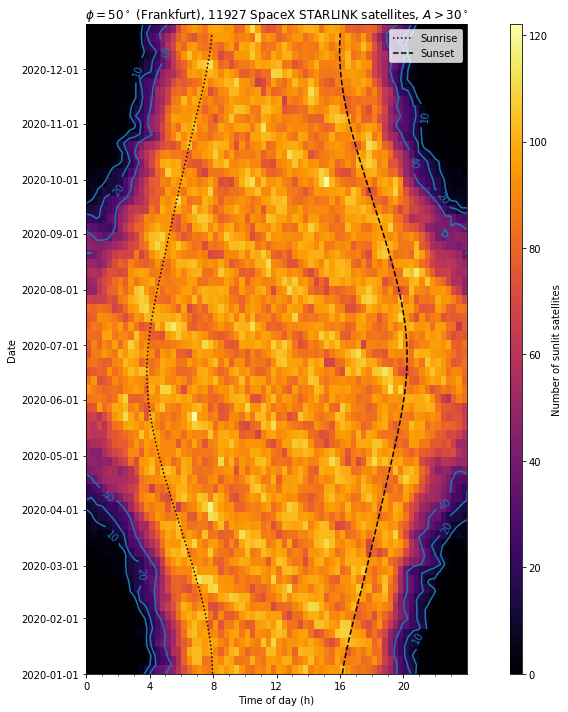

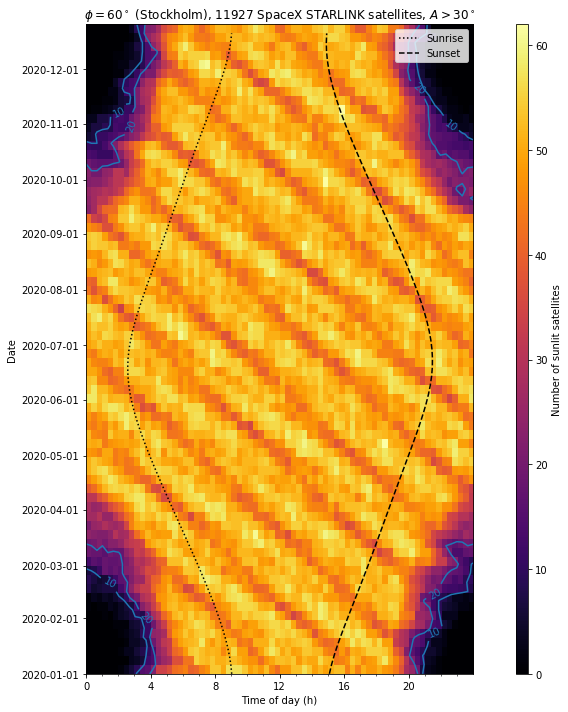

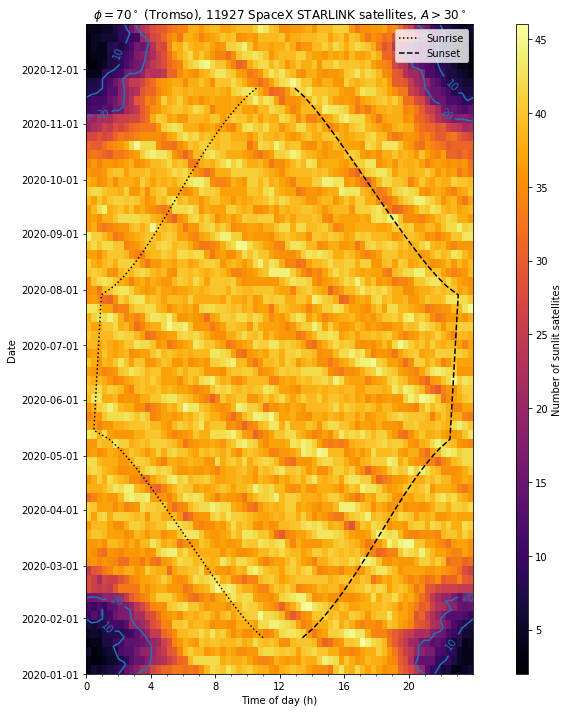

In [13]:
create_plot("LSST", -30, "starlink_lsst.png")
create_plot("Mauna Kea", 20, "starlink_maunakea.png")
create_plot("Houston", 30, "starlink_houston.png")
create_plot("New York", 40, "starlink_newyork.png")
create_plot("Frankfurt", 50, "starlink_frankfurt.png")
create_plot("Stockholm", 60, "starlink_stockholm.png")
create_plot("Tromso", 70, "starlink_tromso.png")